## Import des utilitaires

In [1]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision
import numpy as np
import plotly.express as px
import random
from PIL import Image

Seed = 999
torch.manual_seed(Seed)
device ='cuda:0' if torch.cuda.is_available() else 'cpu'

### Préparation des données

#### Ecritures des constantes : 

In [2]:
batch_size = 4
image_width = 448
image_height = 448
nc = 3

n_classes=4
image_size=(image_width,image_height)

TRAIN_DIR = "DATA/Train"
TEST_DIR = "DATA/Test"

#### Augmentation de donnée

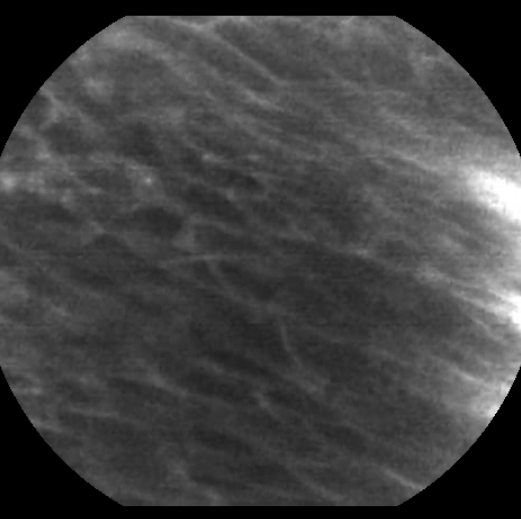

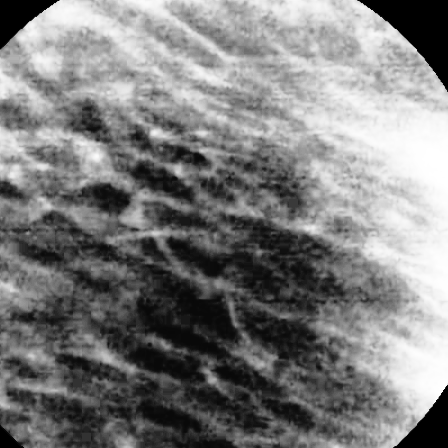

In [3]:
data_augmenter = transforms.Compose([
    transforms.RandomCrop(image_size),
    # transforms.CenterCrop((image_size[0]-100,image_size[1]-100)),
    transforms.Resize((image_size)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomAdjustSharpness(sharpness_factor=0.5,p=0.5),
    torchvision.transforms.AutoAugment(),
    # transforms.functional.autocontrast,
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), (1,1, 1)),
])
data_format = transforms.Compose([
    transforms.CenterCrop((image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), (1,1, 1)),
])

###
## Example

im=Image.open('DATA/Train/0/im_0_0.png')
display(im,transforms.ToPILImage()(data_augmenter(im)))

#### Maintenant, préparons les Datasets/Dataloader

Batch d'entraînement :


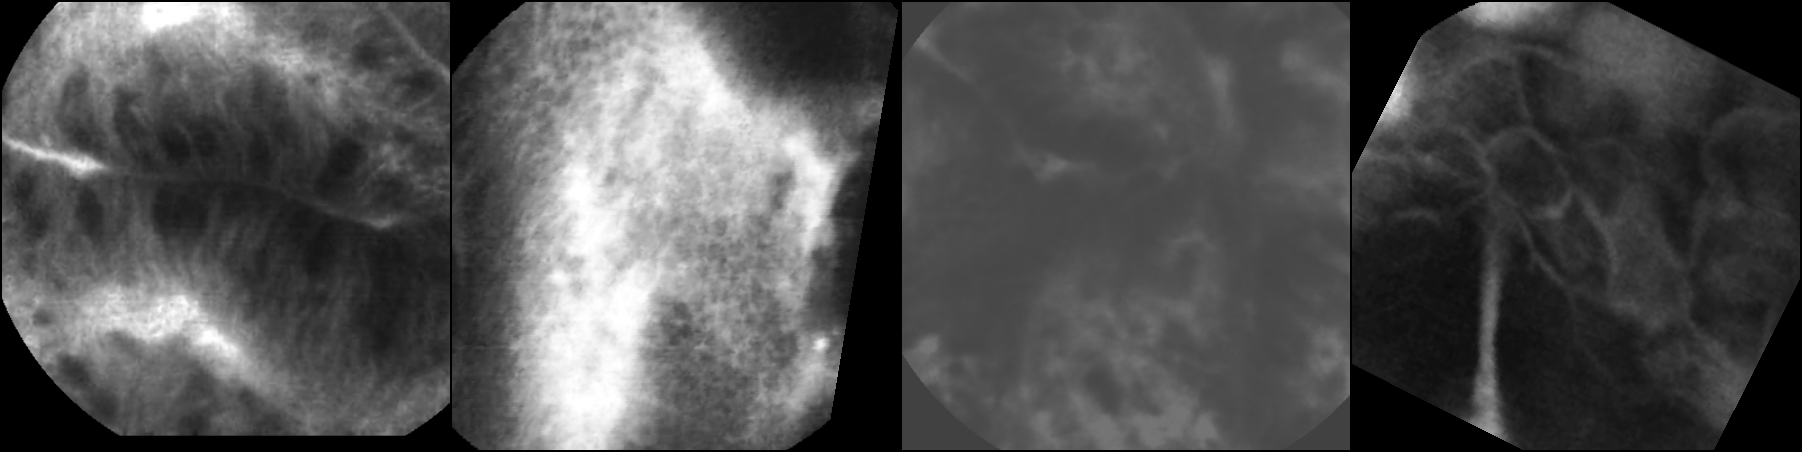

Batch de test :


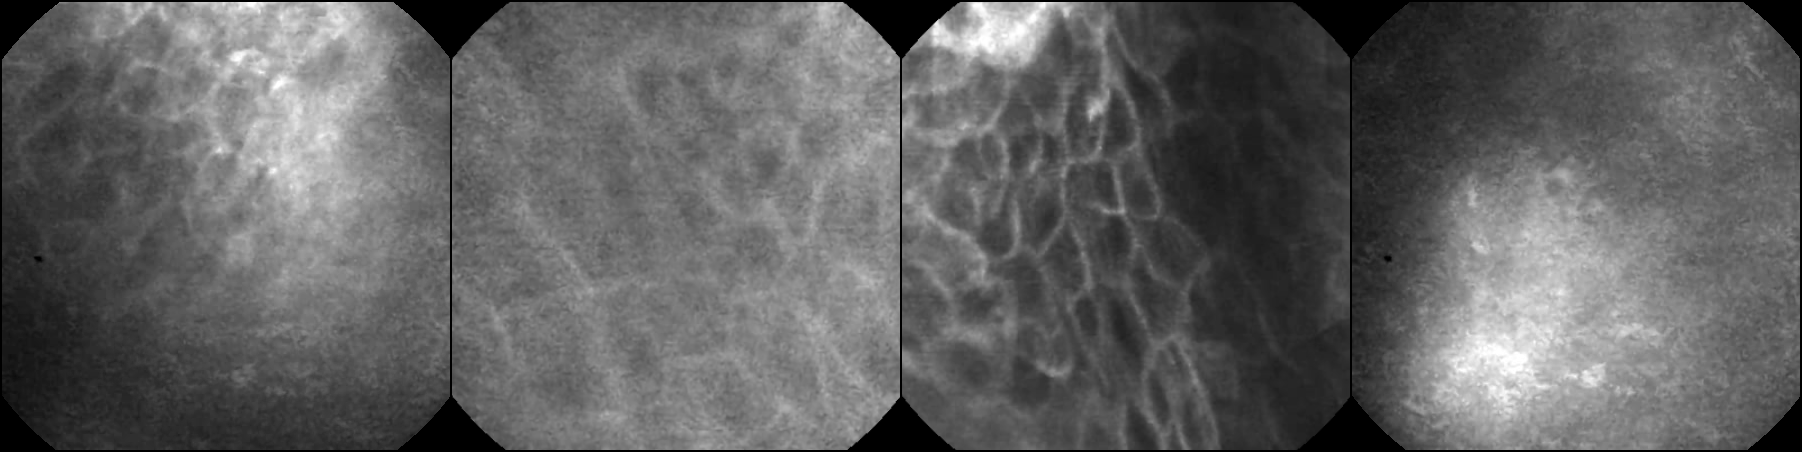

In [4]:
###
# Création des Datasets

train_set = dset.ImageFolder(root=TRAIN_DIR,
                           transform=data_augmenter)

test_set = dset.ImageFolder(root=TEST_DIR,
                           transform=data_format)

###
# Ecriture des DataLoaders

train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=3)

test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=3)

###
# Vérification

print("Batch d'entraînement :")

display(transforms.ToPILImage()(
    vutils.make_grid(
        next(iter(train_loader))[0]))
       )


print("Batch de test :")

display(transforms.ToPILImage()(
    vutils.make_grid(
        next(iter(test_loader))[0]))
       )

In [5]:
#pytorch-lightning on top of PyTorch framework
import pytorch_lightning as pl
import torchmetrics 
from pytorch_lightning.callbacks import ModelCheckpoint 

#for efficient model transfer learning
from efficientnet_pytorch import EfficientNet

In [6]:
class MKT_ConvNext(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.norm = nn.BatchNorm2d(3)
        self.convnext = torchvision.models.convnext_small(weights=torchvision.models.ConvNeXt_Small_Weights.DEFAULT)
        self.convnext.fc = nn.Linear(in_features=512, out_features=10, bias=True)
        self.metric = torchmetrics.Accuracy()
        self.lr = 1e-5
        
    def forward(self,x):
        out = self.norm(x)
        out = self.convnext(out)
        
        return nn.Softmax()(out)
  
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),lr = self.lr)
        return optimizer
    
    def test_step(self, batch, batch_idx):
        x,y = batch
        y_hat = self(x)
        return nn.functional.cross_entropy(y_hat,y)
    
    def training_step(self,batch,batch_idx):
        x,y = batch
        y_hat = self(x)
        loss = nn.functional.cross_entropy(y_hat,y)
        # logs metrics for each training_step - [default:True],
        # the average across the epoch, to the progress bar and logger-[default:False]
        acc = self.metric(y_hat,y)
        self.log("train_acc",acc,on_step=False,on_epoch=True,prog_bar=True,logger=True),
        self.log("train_loss",loss,on_step=False,on_epoch=True,prog_bar=True,logger=True)
        return loss
  
    def validation_step(self,batch,batch_idx):
        x,y = batch
        y_hat = self(x)
        loss = nn.functional.cross_entropy(y_hat,y)
        acc = self.metric(y_hat,y)
        self.log("val_acc",acc,prog_bar=True,logger=True),
        self.log("val_loss",loss,prog_bar=True,logger=True)

model = MKT_ConvNext()

In [7]:


model_checkpoint = ModelCheckpoint(monitor = "val_loss",
                                   verbose=True,
                                   filename="Small_{epoch}_{val_loss:.4f}")



In [8]:
# check = torch.load("ConNextSmall.ckpt")
model.load_state_dict(torch.load("ConNextSmall.ckpt")['state_dict'])

<All keys matched successfully>

In [10]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 6007

In [22]:
model.lr = 1e-06

In [55]:
trainer = pl.Trainer(accelerator='gpu',
                     max_epochs=1,
                     callbacks=[model_checkpoint],) 

trainer.fit(model,train_loader,test_loader) 

#manually you can save best checkpoints - 
# trainer.save_checkpoint("ConNextSmall.ckpt")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/geindreau/data_challenges/ENS_DataChallenges/2019/MKT/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type        | Params
-----------------------------------------
0 | norm     | BatchNorm2d | 6     
1 | convnext | ConvNeXt    | 50.2 M
2 | metric   | Accuracy    | 0     
-----------------------------------------
50.2 M    Trainable params
0         Non-trainable params
50.2 M    Total params
200.915   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/tmp/ipykernel_30887/492600588.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(out)


Training: 0it [00:00, ?it/s]

/home/geindreau/.cache/pypoetry/virtualenvs/mkt-KOF0R2Oh-py3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [12]:
trainer.save_checkpoint("ConNextSmall.ckpt")

In [42]:
import pandas as pd
test = pd.read_csv('submission.csv')

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        filename = self.df.loc[index, "image_filename"]
        # label = self.class2index[self.df[index, "LABEL"]]
        image = Image.open(f"{self.images_folder}/{filename}")
        if self.transform is not None:
            image = self.transform(image)
        return image, ''

In [47]:
pred = CustomDataset('submission.csv',"DATA/VAL/TestSetImagesDir/part_1",transform=data_format)
pred_loader = torch.utils.data.DataLoader(pred,
                                          batch_size=4,
                                          shuffle=False,
                                          num_workers=3)

In [49]:
model.to(device)
res = []
for img,labels in pred_loader:
    res += list(model(img.to(device)).argmax(axis=1).to('cpu').numpy())
    del img

/tmp/ipykernel_31947/492600588.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(out)


In [54]:
test['class_number'] = res

In [56]:
test.to_csv('res.csv',index=False)